## Work Environment Setup

In [243]:
import sys

In [244]:
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install gym==0.25.1
!{sys.executable} -m pip install gym[toy_text]==0.25.1

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [666]:
import numpy as np
import gym
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets


from mpl_toolkits.axes_grid1 import ImageGrid
import time
import math
import random

from timeit import default_timer as timer
%matplotlib inline

## Functions

### Misc Functions

In [534]:
def movingAverage(data, window):
  cumsum = np.cumsum(np.insert(data,0,0))
  ma = (cumsum[window:] - cumsum[:-window]) / window
  return ma

In [247]:
def calcPolicy(q_table):
  policy = np.empty((4,4))
  index = 0
  for row in q_table:
    if np.sum(row) == 0:
      policy[int(index/4),int(index%4) ] = float('nan')
    else:
      policy[int(index/4),int(index%4) ] = np.argmax(row)
    index += 1
  return policy

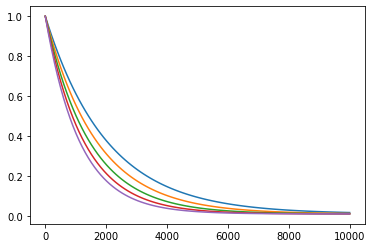

In [248]:
def explorationDecayRate(episodes,max,min,factor):
  decay_rate = (max-min)/episodes
  x = np.linspace(0,episodes,num=100)
  y = min+(max-min)*np.exp(-decay_rate*factor*x)
  plt.plot(x,y)

for i in range(5,10):
  explorationDecayRate(10000,1,0.01,i)

### Training and Testing Functions

#### Training Episode Function

In [283]:
def runEpisode(env, q_table, learning_rate, discount, epsilon,  max_steps=200):
    state = env.reset()
    episode_score = 0
    for step in range(max_steps):

        # Decide an action

        if random.uniform(0, 1) > epsilon:
            action = np.argmax(q_table[state])
        else:
            action = env.action_space.sample()

        new_state, reward, terminated, _, _ = env.step(action)

        episode_score += reward

        current_q = q_table[state, action]
        max_future_q = np.max(q_table[new_state])

        q_table[state, action] = (
            1 - learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)

        state = new_state

        if terminated:
            break

    return q_table, episode_score


#### Train Model

In [710]:
class HyperParams:
    def __init__(self, learning_rate, discount, epsilon_decay, epsilon_max = float(1), epsilon_min = 0.05, epsilon_delay = 0):
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon_decay = epsilon_decay
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_delay = epsilon_delay

def trainModel(env, episodes, hyper_params, start_episode=0, prev_q_table = None):
    hp = hyper_params
    q_table = np.zeros([env.observation_space.n, env.action_space.n]) if prev_q_table is None else prev_q_table
    
    all_rewards = []
    epsilon = hp.epsilon_max
    previous_episode_score = -float('inf')

    for episode in range(start_episode, start_episode + episodes):

        q_table, episode_score = runEpisode(
            env, q_table, hp.learning_rate, hp.discount, epsilon)

        all_rewards.append(episode_score)
        if epsilon > hp.epsilon_min and episode > hp.epsilon_delay and episode_score > previous_episode_score:
            epsilon = hp.epsilon_min + \
                (hp.epsilon_max - hp.epsilon_min) * \
                np.exp(-hp.epsilon_decay * (episode-hp.epsilon_delay))

    return q_table, all_rewards


#### Test Model

In [373]:
def testModel(env, q_table, max_steps = 200):
  test_reward = 0
  state = env.reset()
  for step in range(max_steps):
    action = np.argmax(q_table[state])
    state, reward, terminated, _, _ = env.step(action)
    test_reward += reward
    if terminated:
      break
    
  return test_reward
  
def runTests(env, q_table, num_tests):
  all_scores = []
  
  for i in range(num_tests):
    all_scores.append(testModel(env, q_table))
  
  average_score = np.mean(all_scores)
  return average_score
    

#### Train and Test

In [412]:
def trainAndTest(env, episodes, test_interval, test_iterations, hyper_params):
  q_table = None
  current_episode = 0
  
  episode_array = [0]
  score_array = [0]
  rewards_array = []
  
  while current_episode < episodes:
    q_table, rewards = trainModel(env, test_interval, hyper_params, current_episode, q_table )
    current_episode += test_interval
    
    
    episode_array.append(current_episode)
    score_array.append(runTests(env, q_table, test_iterations))
    rewards_array.append(rewards)
    
    
  return  q_table, episode_array, score_array, rewards_array

### Experiment Function


In [711]:
def runExperiment(env, parameter, experiment_space, training_event_per_interval, number_episodes, train_test_interval_size, test_iterations):

    

    hyper_params = HyperParams(0.8, 0.9, 0.0001)

    # setup progress bar
    learning_rate_scores = []
    test_progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=len(experiment_space),
        description='experiment value:',
        bar_style='info',
        style={'bar_color': 'red'},
        orientation='horizontal'
    )
    event_progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=training_event_per_interval,
        description='training event:',
        bar_style='info',
        style={'bar_color': 'red'},
        orientation='horizontal'
    )
    display(test_progress)
    display(event_progress)

    # run experiment

    experiment_results = []

    for experiment in range(len(experiment_space)):
        experiment_value = experiment_space[experiment]
        setattr(hyper_params, parameter, experiment_value)
        
        test_progress.value = experiment

        test_score = []

        x_axis = []
        for event in range(training_event_per_interval):

            _, x_axis, score, _ = trainAndTest(
                env, number_episodes, train_test_interval_size, test_iterations, hyper_params)

            test_score.append(score)

            event_progress.value = event+1

        average_test_score = np.mean(test_score, 0)

        experiment_results.append(average_test_score)

        

    event_progress.close()
    test_progress.close()
    return experiment_results


### Result Plotting Functions

In [ ]:
def plotResults(parameter, experiment_space, experiment_results, number_episodes, train_test_interval_size, x_axis_scale = 'linear'):
    experiment_intervals = math.ceil(
        number_episodes / train_test_interval_size)

    range_start_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=experiment_intervals,
        step=1,
        description='Start:',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=False
    )
    range_end_slider = widgets.IntSlider(
        value=experiment_intervals,
        min=0,
        max=experiment_intervals,
        step=1,
        description='End:',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=False
    )
    slice_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=experiment_intervals,
        step=1,
        description='Episode:',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=False,
        readout_format='d'
    )

    def figureRange(x, y):
        for test in range(len(experiment_space)):
            plt.plot(np.arange(x*train_test_interval_size, y*train_test_interval_size, train_test_interval_size),
                     np.asarray(experiment_results)[test][x:y], label=experiment_space[test])
        plt.legend(title="Training Event", bbox_to_anchor=(1, 1))
        plt.title(parameter)
        plt.show()

        range_end_slider.min = x+1
        range_start_slider.max = y-1

    

    def plotSlice(x):
        slice = np.asarray(experiment_results)[:, x]
        figure, axes = plt.subplots()
        axes.plot(experiment_space[:], slice)
        axes.set_xscale(x_axis_scale)
        axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        plt.title("{0} vs Score at Episode {1}".format(parameter, x*train_test_interval_size))
        plt.xlabel("{0}".format(parameter))

        plt.ylabel("Score at episode")
        plt.show()

    widgets.interact(figureRange, x=range_start_slider, y=range_end_slider)
    widgets.interact(plotSlice, x=slice_slider)  

    figure, axes = plt.subplots()
    axes.plot(experiment_space[:], experiment_results)
    axes.set_xscale(x_axis_scale)
    axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    plt.title("{0} vs Score at episode (All)".format(parameter))
    plt.xlabel("{0}".format(parameter))
    plt.ylabel("Score at episode")
    plt.show()


## Testing The Functions

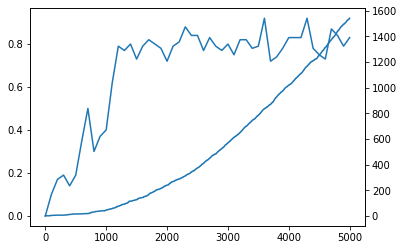

In [458]:
env = gym.make("FrozenLake-v1", map_name="4x4",
               is_slippery=True, new_step_api=True)

hyper_params = HyperParams(0.1, 0.99, 0.001)

q_table, x_axis, y_axis, rewards = trainAndTest(env, 5000, 100, 100, hyper_params)


fig, ax = plt.subplots()
twin = ax.twinx()
cumulative_rewards = np.cumsum(rewards)

ax.plot(x_axis, y_axis)
twin.plot(cumulative_rewards)



plt.show()


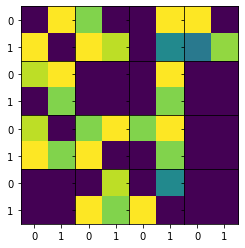

In [ ]:


fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

for ax, im in zip(grid, q_table.reshape(16,2,2)[:,:,0:]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

## Experiments

### Learning Rate Experiment

In [596]:
# Run Experiment
env = gym.make("FrozenLake-v1", map_name="4x4",
            is_slippery=False, new_step_api=True)

experiment_intervals = 5
training_event_per_interval = 5

number_episodes = 1000
train_test_interval_size = 100
test_iterations = 20

# hyper parameters

parameter = "learning_rate"
max_experiment_value = 1
min_experiment_value = 0
learning_rate_experiment_space = np.linspace(
        min_experiment_value, max_experiment_value, experiment_intervals)

learning_rate_results = runExperiment(env, parameter, learning_rate_experiment_space, training_event_per_interval, number_episodes, train_test_interval_size, test_iterations)


FloatProgress(value=0.0, bar_style='info', description='experiment value:', max=1.0, style=ProgressStyle(bar_c…

FloatProgress(value=0.0, bar_style='info', description='training event:', max=5.0, style=ProgressStyle(bar_col…

interactive(children=(IntSlider(value=0, description='Start:', max=10, readout=False), IntSlider(value=10, des…

interactive(children=(IntSlider(value=0, description='Episode:', max=10, readout=False), Output()), _dom_class…

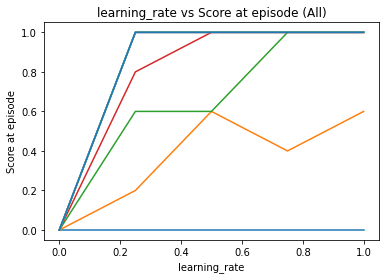

In [696]:
# Plot Results
plotResults("learning_rate", learning_rate_experiment_space,learning_rate_results, number_episodes, train_test_interval_size )

### Discount Experiment

In [690]:
# Run Experiment

env = gym.make("FrozenLake-v1", map_name="4x4",
            is_slippery=False, new_step_api=True)

experiment_intervals = 10
training_event_per_interval = 20

number_episodes = 1000
train_test_interval_size = 100
test_iterations = 10

# hyper parameters

parameter = "discount"
max_experiment_value = math.log(0.99)
min_experiment_value = math.log(0.9)
# discount_experiment_space = np.linspace(
#         min_experiment_value, max_experiment_value, num = experiment_intervals)
discount_experiment_space = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,0.999,0.9999]

discount_results = runExperiment(env, parameter, discount_experiment_space, training_event_per_interval, number_episodes, train_test_interval_size, test_iterations)


FloatProgress(value=0.0, bar_style='info', description='experiment value:', max=12.0, style=ProgressStyle(bar_…

FloatProgress(value=0.0, bar_style='info', description='training event:', max=20.0, style=ProgressStyle(bar_co…

interactive(children=(IntSlider(value=0, description='Start:', max=10, readout=False), IntSlider(value=10, des…

interactive(children=(IntSlider(value=0, description='Episode:', max=10, readout=False), Output()), _dom_class…

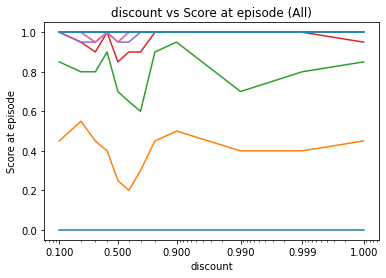

In [695]:
# plot results
plotResults("discount", discount_experiment_space,discount_results, number_episodes, train_test_interval_size, x_axis_scale = 'logit' )

### Exploration Experiment

In [714]:
# Run Experiment

env = gym.make("FrozenLake-v1", map_name="4x4",
            is_slippery=False, new_step_api=True)

experiment_intervals = 10
training_event_per_interval = 10

number_episodes = 1000
train_test_interval_size = 100
test_iterations = 10

# hyper parameters

parameter = "epsilon_decay"
max_experiment_value = math.log(0.00001)
min_experiment_value = math.log(0.1)
# epsilon_experiment_space = np.linspace(
#         min_experiment_value, max_experiment_value, num = experiment_intervals)
epsilon_experiment_space = [0.8,0.4,0.2,0.1,0.05,0.01,0.001,0.0001]

epsilon_results = runExperiment(env, parameter, epsilon_experiment_space, training_event_per_interval, number_episodes, train_test_interval_size, test_iterations)


FloatProgress(value=0.0, bar_style='info', description='experiment value:', max=8.0, style=ProgressStyle(bar_c…

FloatProgress(value=0.0, bar_style='info', description='training event:', max=10.0, style=ProgressStyle(bar_co…

interactive(children=(IntSlider(value=0, description='Start:', max=10, readout=False), IntSlider(value=10, des…

interactive(children=(IntSlider(value=0, description='Episode:', max=10, readout=False), Output()), _dom_class…

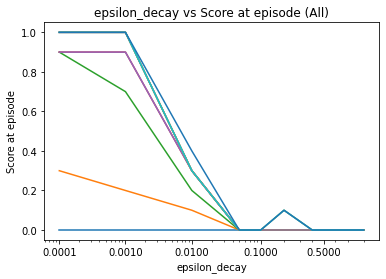

In [715]:
# plot results
plotResults(parameter, epsilon_experiment_space,epsilon_results, number_episodes, train_test_interval_size, x_axis_scale = 'logit' )